In [7]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from statsmodels.tsa.arima.model import ARIMA
from statsmodels.tsa.stattools import adfuller
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.stats.diagnostic import acorr_ljungbox
import yfinance
import warnings
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import TimeSeriesSplit
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
from sklearn.tree import export_graphviz
import pydot
warnings.filterwarnings('ignore')

data = pd.read_csv('data\df.csv',sep='|')
data['date'] = pd.to_datetime(data['date'])

DXY = yfinance.download('DX-Y.NYB', start='1999-01-04', end='2025-09-19')
DXY = DXY.reset_index()[['Date','Close']]
DXY.columns = ['date','DXY']
data=data.merge(DXY, on='date', how='left')

GDPM = pd.read_csv('GDP Monthly.csv',sep=',')
GDPM['date'] = pd.to_datetime(GDPM['timestamp'])
GDPM['year'] = GDPM['date'].dt.year
GDPM['month'] = GDPM['date'].dt.month
GDPM['CroissM'] = GDPM['EIA/GDPQXUS/USA'].diff()

data['year'] = data['date'].dt.year
data['month'] = data['date'].dt.month

data = data.merge(GDPM, on=['year', 'month'], how='left')
data.drop(['timestamp','date_y','year','month'], axis=1, inplace=True)
data['DXY'].fillna(method='ffill', inplace=True)
print(data.columns)
data.set_index('date_x', inplace=True)

[*********************100%***********************]  1 of 1 completed


Index(['date_x', 'close', 'volume', 'high', 'low', 'pe',
       'num_daily_adv_minus_decl', 'mov_avg_20d', 'best_eps', 'dvd_sh_last',
       'rsi_3d', 'rsi_9d', 'rsi_14d', 'rsi_30d', 'mov_avg_10d', 'mov_avg_30d',
       'mov_avg_50d', 'pb', 'pib_pct', 'pib', 'vix', 'i', 'i_future',
       'inflation', 'gold', 'gold_pct', 'gold_volume', 'brent', 'brent_pct',
       'brent_volume', 'cible', 'returns', 'vol', 'score', 'momentum_10d',
       'macd', 'macd_signal', 'bb_upper', 'bb_lower', 'mov_avg_100d',
       'mov_avg_200d', 'mov_avg_10_50_diff', 'mov_avg_20_50_diff',
       'close_minus_10d', 'close_minus_20d', 'close_minus_30d',
       'close_minus_50d', 'close_minus_100d', 'close_minus_200d', 'DXY',
       'EIA/GDPQXUS/USA', 'CroissM'],
      dtype='object')


 RANDOM FOREST - PRÉDICTION S&P 500
🚀 Entraînement du Random Forest
   Train: 5329 observations
   Test:  1333 observations
✅ Modèle entraîné avec succès!

📊 PERFORMANCES DU MODÈLE
TRAIN: MAE = 11.38 | R² = 0.9990
TEST:  MAE = 1474.35 | RMSE = 1681.85
       R² = -2.8798 | MAPE = 30.00%


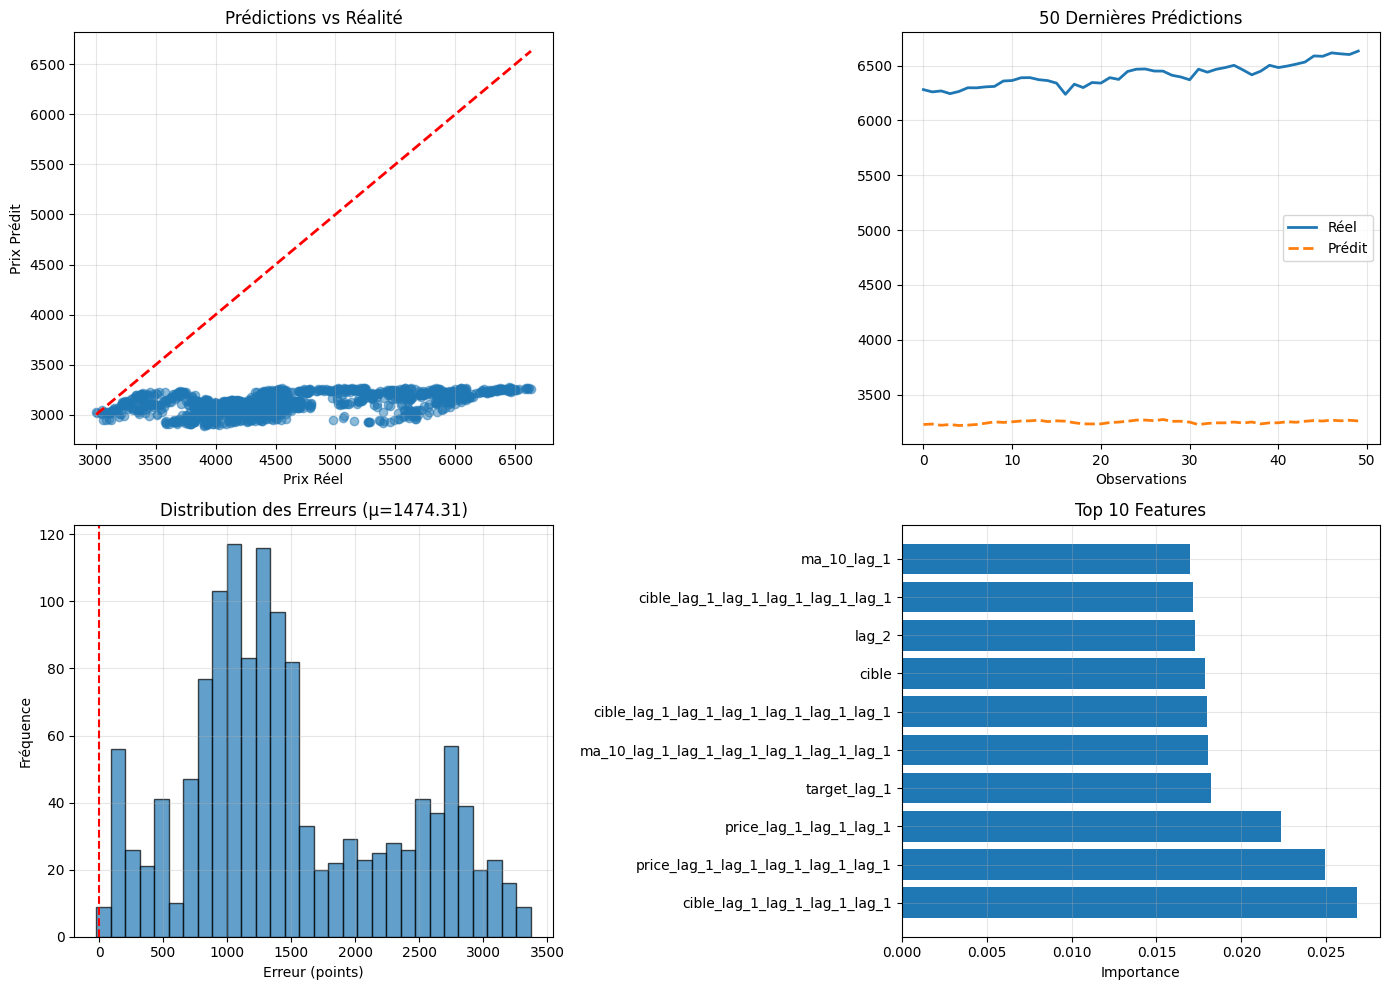

⚠️ Pas assez de données pour faire une prédiction


In [12]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import TimeSeriesSplit
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score

class SP500RandomForest:
    """
    Random Forest optimisé pour prédire le prix du S&P 500
    """
    
    def __init__(self, forecast_horizon=1):
        self.model = None
        self.forecast_horizon = forecast_horizon
        self.feature_names = []
        self.X_train = None
        self.X_test = None
        self.y_train = None
        self.y_test = None
        
    def prepare_features(self, df, target_col='close'):
        """
        Crée les features techniques essentielles
        """
        df = df.copy()
        
        # === FEATURES ESSENTIELLES ===
        
        # 1. Prix passés (lags)
        for lag in [1, 2, 3, 5, 10, 20]:
            df[f'lag_{lag}'] = df[target_col].shift(lag)
        
        # 2. Rendements
        for period in [1, 2, 5, 10, 20]:
            df[f'return_{period}d'] = df[target_col].pct_change(period)
        
        # 3. Moyennes mobiles et ratios
        for window in [5, 10, 20, 50]:
            ma = df[target_col].rolling(window).mean()
            df[f'ma_{window}'] = ma
            df[f'price_ma_ratio_{window}'] = df[target_col] / ma
        
        # 4. Volatilité (écart-type des rendements)
        returns = df[target_col].pct_change()
        for window in [5, 10, 20]:
            df[f'volatility_{window}d'] = returns.rolling(window).std()
        
        # 5. RSI simplifié
        delta = df[target_col].diff()
        gain = delta.where(delta > 0, 0).rolling(14).mean()
        loss = -delta.where(delta < 0, 0).rolling(14).mean()
        rs = gain / loss
        df['rsi'] = 100 - (100 / (1 + rs))
        
        # 6. Bollinger Bands
        ma20 = df[target_col].rolling(20).mean()
        std20 = df[target_col].rolling(20).std()
        df['bb_upper'] = ma20 + (2 * std20)
        df['bb_lower'] = ma20 - (2 * std20)
        df['bb_position'] = (df[target_col] - df['bb_lower']) / (df['bb_upper'] - df['bb_lower'])
        
        # 7. Volume features (si disponible)
        if 'volume' in df.columns:
            df['volume_ma'] = df['volume'].rolling(20).mean()
            df['volume_ratio'] = df['volume'] / df['volume_ma']
        
        # === VARIABLE CIBLE ===
        df['target'] = df[target_col].shift(-self.forecast_horizon)
        
        return df
    
    def train(self, data, target_col='close', test_size=0.2, 
              n_estimators=100, max_depth=20, min_samples_split=20):
        """
        Entraîne le modèle avec split temporel
        """
        # Préparer les features
        df = self.prepare_features(data, target_col)
        
        # Sélectionner les colonnes numériques (exclure prix et cible)
        exclude = [target_col, 'target', 'open', 'high', 'low', 'close']
        feature_cols = [col for col in df.columns 
                       if col not in exclude and df[col].dtype in ['float64', 'int64']]
        
        # Supprimer les NaN
        df_clean = df[feature_cols + ['target']].dropna()
        
        # Split temporel
        split_idx = int(len(df_clean) * (1 - test_size))
        
        self.X_train = df_clean[feature_cols].iloc[:split_idx]
        self.X_test = df_clean[feature_cols].iloc[split_idx:]
        self.y_train = df_clean['target'].iloc[:split_idx]
        self.y_test = df_clean['target'].iloc[split_idx:]
        self.feature_names = feature_cols
        
        # Entraîner le modèle
        print(f"🚀 Entraînement du Random Forest")
        print(f"   Train: {len(self.X_train)} observations")
        print(f"   Test:  {len(self.X_test)} observations")
        
        self.model = RandomForestRegressor(
            n_estimators=n_estimators,
            max_depth=max_depth,
            min_samples_split=min_samples_split,
            min_samples_leaf=10,
            max_features='sqrt',
            random_state=42,
            n_jobs=-1
        )
        
        self.model.fit(self.X_train, self.y_train)
        print("✅ Modèle entraîné avec succès!")
        
        return self
    
    def evaluate(self):
        """
        Évalue les performances du modèle
        """
        if self.model is None:
            raise ValueError("Le modèle doit être entraîné avant l'évaluation")
        
        # Prédictions
        y_pred_train = self.model.predict(self.X_train)
        y_pred_test = self.model.predict(self.X_test)
        
        # Métriques
        print("\n📊 PERFORMANCES DU MODÈLE")
        print("="*50)
        
        # Train
        train_mae = mean_absolute_error(self.y_train, y_pred_train)
        train_r2 = r2_score(self.y_train, y_pred_train)
        print(f"TRAIN: MAE = {train_mae:.2f} | R² = {train_r2:.4f}")
        
        # Test
        test_mae = mean_absolute_error(self.y_test, y_pred_test)
        test_rmse = np.sqrt(mean_squared_error(self.y_test, y_pred_test))
        test_r2 = r2_score(self.y_test, y_pred_test)
        test_mape = np.mean(np.abs((self.y_test - y_pred_test) / self.y_test)) * 100
        
        print(f"TEST:  MAE = {test_mae:.2f} | RMSE = {test_rmse:.2f}")
        print(f"       R² = {test_r2:.4f} | MAPE = {test_mape:.2f}%")
        
        # Visualisation
        self._plot_results(y_pred_test)
        
        return {
            'test_mae': test_mae,
            'test_rmse': test_rmse,
            'test_r2': test_r2,
            'test_mape': test_mape
        }
    
    def _plot_results(self, y_pred_test):
        """
        Visualise les résultats
        """
        fig, axes = plt.subplots(2, 2, figsize=(14, 10))
        
        # 1. Scatter plot
        axes[0, 0].scatter(self.y_test, y_pred_test, alpha=0.5)
        min_val, max_val = self.y_test.min(), self.y_test.max()
        axes[0, 0].plot([min_val, max_val], [min_val, max_val], 'r--', lw=2)
        axes[0, 0].set_xlabel('Prix Réel')
        axes[0, 0].set_ylabel('Prix Prédit')
        axes[0, 0].set_title('Prédictions vs Réalité')
        axes[0, 0].grid(True, alpha=0.3)
        
        # 2. Série temporelle (50 dernières)
        n_show = min(50, len(self.y_test))
        recent_test = self.y_test.tail(n_show)
        recent_pred = pd.Series(y_pred_test, index=self.y_test.index).tail(n_show)
        
        axes[0, 1].plot(recent_test.values, label='Réel', linewidth=2)
        axes[0, 1].plot(recent_pred.values, label='Prédit', linestyle='--', linewidth=2)
        axes[0, 1].set_title(f'{n_show} Dernières Prédictions')
        axes[0, 1].set_xlabel('Observations')
        axes[0, 1].legend()
        axes[0, 1].grid(True, alpha=0.3)
        
        # 3. Distribution des erreurs
        errors = self.y_test - y_pred_test
        axes[1, 0].hist(errors, bins=30, edgecolor='black', alpha=0.7)
        axes[1, 0].axvline(x=0, color='red', linestyle='--')
        axes[1, 0].set_xlabel('Erreur (points)')
        axes[1, 0].set_ylabel('Fréquence')
        axes[1, 0].set_title(f'Distribution des Erreurs (μ={errors.mean():.2f})')
        axes[1, 0].grid(True, alpha=0.3)
        
        # 4. Feature importance (top 10)
        importance_df = pd.DataFrame({
            'feature': self.feature_names,
            'importance': self.model.feature_importances_
        }).nlargest(10, 'importance')
        
        axes[1, 1].barh(importance_df['feature'], importance_df['importance'])
        axes[1, 1].set_xlabel('Importance')
        axes[1, 1].set_title('Top 10 Features')
        axes[1, 1].grid(True, alpha=0.3)
        
        plt.tight_layout()
        plt.show()
    
    def predict_next(self, data, target_col='close'):
        """
        Prédit le prochain prix
        """
        if self.model is None:
            raise ValueError("Le modèle doit être entraîné")
        
        # Préparer les features pour la dernière observation
        df = self.prepare_features(data, target_col)
        
        # Utiliser les mêmes features que pour l'entraînement
        last_row = df[self.feature_names].iloc[-1:].dropna()
        
        if len(last_row) == 0:
            print("⚠️ Pas assez de données pour faire une prédiction")
            return None
        
        # Prédiction
        prediction = self.model.predict(last_row)[0]
        current_price = data[target_col].iloc[-1]
        
        print("\n🎯 PRÉDICTION")
        print("="*40)
        print(f"Prix actuel:      {current_price:.2f}")
        print(f"Prix prédit (+{self.forecast_horizon}j): {prediction:.2f}")
        print(f"Variation:        {prediction - current_price:+.2f}")
        print(f"Variation %:      {((prediction/current_price) - 1) * 100:+.2f}%")
        
        return prediction

# ============================================
# UTILISATION SIMPLIFIÉE
# ============================================

def run_sp500_prediction(data, target_column='close'):
    """
    Fonction principale pour exécuter la prédiction
    """
    print("="*60)
    print(" RANDOM FOREST - PRÉDICTION S&P 500")
    print("="*60)
    
    # 1. Créer et entraîner le modèle
    model = SP500RandomForest(forecast_horizon=1)
    
    model.train(
        data=data,
        target_col=target_column,
        test_size=0.2,
        n_estimators=100,  # Augmenter pour plus de précision
        max_depth=20,
        min_samples_split=20
    )
    
    # 2. Évaluer les performances
    metrics = model.evaluate()
    
    # 3. Faire une prédiction pour demain
    next_price = model.predict_next(data, target_column)
    
    return model, metrics

# Exemple d'utilisation
if __name__ == "__main__":
    # Supposons que 'data' est votre DataFrame avec les colonnes: date, open, high, low, close, volume
    model, metrics = run_sp500_prediction(data, 'close')

In [28]:
import pandas as pd
import numpy as np
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_absolute_error
import matplotlib.pyplot as plt

window_years = 3  # nombre d'années de données pour entraîner (ex : 3 ans)
trading_days_per_year = 250
window_size = window_years * trading_days_per_year  # ~756 jours
start_date = '2020-01-01'
end_date = '2025-09-18'
df = data.copy()

features = df.drop(columns=['cible'])
target = df['cible']

# === Initialisation des listes === #
predictions = []
true_values = []
prediction_dates = []

# === Boucle rolling === #
for current_date in pd.date_range(start=start_date, end=end_date, freq='B'):  # freq='B' = jours ouvrés
    if current_date not in df.index:
        continue

    end_train_idx = df.index.get_loc(current_date)
    start_train_idx = end_train_idx - window_size

    if start_train_idx < 0:
        continue  # pas assez d'historique

    # Définir les fenêtres d'entraînement et de test
    X_train = features.iloc[start_train_idx:end_train_idx]
    y_train = target.iloc[start_train_idx:end_train_idx]

    X_test = features.loc[[current_date]]
    y_test = target.loc[current_date]

    # Entraîner le modèle
    model = RandomForestRegressor(n_estimators=100, random_state=42, n_jobs=-1)
    model.fit(X_train, y_train)

    # Prédire
    y_pred = model.predict(X_test)[0]

    # Stocker
    predictions.append(y_pred)
    true_values.append(y_test)
    prediction_dates.append(current_date)

# === Résultats === #
results = pd.DataFrame({
    'Valeur réelle': true_values,
    'Prédiction': predictions
}, index=prediction_dates)

# === Évaluation === #
mae = mean_absolute_error(results['Valeur réelle'], results['Prédiction'])
print(f"\n✅ MAE global ({start_date} ➜ {end_date}): {mae:.2f}\n")

print(results.head())

# === Affichage === #
plt.figure(figsize=(12,6))
plt.plot(results.index, results['Valeur réelle'], label='Valeur réelle', color='blue')
plt.plot(results.index, results['Prédiction'], label='Prédiction', color='red', alpha=0.7)
plt.title("Modèle Random Forest avec fenêtre glissante")
plt.xlabel("Date")
plt.ylabel("S&P 500 (ou cible)")
plt.legend()
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()


# Calculate the absolute errors
# errors = abs(predictions - y_test)

# Print out the mean absolute error (mae)
# print('Mean Absolute Error:', round(np.mean(errors), 2), 'degrees.')

# Calculate mean absolute percentage error (MAPE)
# mape = 100 * (errors / y_test)

# Calculate and display accuracy
# accuracy = 100 - np.mean(mape)
# print('Accuracy:', round(accuracy, 2), '%.')

KeyboardInterrupt: 

In [ ]:
df = data.copy()
X = df.drop(['cible','close'], axis=1, inplace=True)
y = df['close'].shift(-1)  # On veut prédire le prix de clôture du jour suivant

# Supprimer la dernière ligne (car y sera NaN à cause du shift)
X = X[:-1]
y = y[:-1]

# ----------------------------
# 4. Train / Test split
# ----------------------------
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, shuffle=False)

# ----------------------------
# 5. Entraînement modèle
# ----------------------------
model = RandomForestRegressor(n_estimators=100, random_state=42)
model.fit(X_train, y_train)

# ----------------------------
# 6. Évaluation
# ----------------------------
y_pred = model.predict(X_test)
print("MSE:", mean_squared_error(y_test, y_pred))
print("R2:", r2_score(y_test, y_pred))

# ----------------------------
# 7. Visualisation
# ----------------------------
plt.figure(figsize=(12,6))
plt.plot(y_test.index, y_test, label="Réel")
plt.plot(y_test.index, y_pred, label="Prédit")
plt.title("Prédiction du S&P500 avec Random Forest")
plt.xlabel("Date")
plt.ylabel("Prix de clôture")
plt.legend()
plt.show()
